In [10]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
import random
import keras
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

import integrated_gradients as ig
import my_utils
from metaplot import Metaplot, one_hot_encode

In [11]:
#import data
df = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/seelig/Samples/GSM3130435_egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# Exclude 5utrs with uAUG
e_test = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]
e_train = e_train[e_train['utr'].apply(lambda x: 'ATG' not in x)]
print("There are ", len(e_test), " UTRs left in the test set.")
print("There are ", len(e_train), " UTRs left in the train set.")


def one_hot_encode(df, col='utr', seq_len=50):
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    vectors=np.empty([len(df),seq_len,4])
    
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


# One-hot encode both training and test UTRs
seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

# Scale the training mean ribosome load values
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))



There are  6014  UTRs left in the test set.
There are  122927  UTRs left in the train set.


In [12]:

#function to plot meta under different conditions
def plot_meta(data, model, subset=None):

    if subset is None:
        data_seq = one_hot_encode(data, seq_len=50)
        data_ig = ig.integrated_gradients(model, data_seq)
        Metaplot(data_ig, colorbar = False)
    
    elif subset == 'lowest_ten':
        data_lowest_ten = data[data['pred'] <= data['pred'].quantile(0.1)]
        print(len(data_lowest_ten))
        lowest_ten_seq = one_hot_encode(data_lowest_ten, seq_len=50)
        lowest_ten_ig = ig.integrated_gradients(model, lowest_ten_seq)
        Metaplot(lowest_ten_ig, colorbar = False)

    elif subset == 'highest_ten':
        highest_ten = e_test[e_test['pred'] >= e_test['pred'].quantile(0.9)]
        print(len(highest_ten))
        highest_ten_seq = one_hot_encode(highest_ten, seq_len=50)
        highest_ten_ig = ig.integrated_gradients(model, highest_ten_seq)
        Metaplot(highest_ten_ig, colorbar = False)
        
    else:
        raise ValueError()


#define model architecture and train on 5utrs (no uAUG) with modified functions from Sample et al.

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []



def train_model(x, y, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='mean_squared_error', optimizer=adam)

    model.fit(x, y, batch_size=128, epochs=nb_epoch, verbose=1)
    return model


def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def one_hot_encode(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    
    # Creat empty matrix.
    vectors=np.empty([len(df),seq_len,4])
    
    # Iterate through UTRs and one-hot encode
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2



#model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
#                   dropout2=0,dropout3=0.2)

model = keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/data/models/mrl_model_no_uorfs.hdf5')

e_test = test_data(df=e_test, model=model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print('r-squared = ', r)

#model.save('/Users/frederickkorbel/Documents/projects/paper/data/models/mrl_model_no_uorfs.hdf5')


r-squared =  0.4164254317556743


<font color=lightblue size=20>Attribution MRL w/o uAUGs</font>

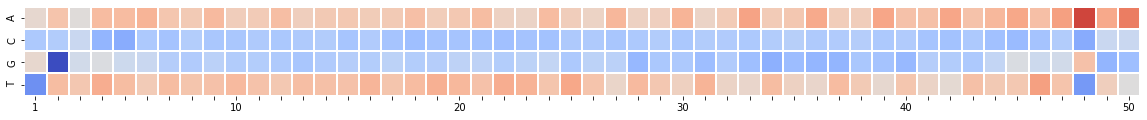

In [13]:
plot_meta(e_test, model)

602


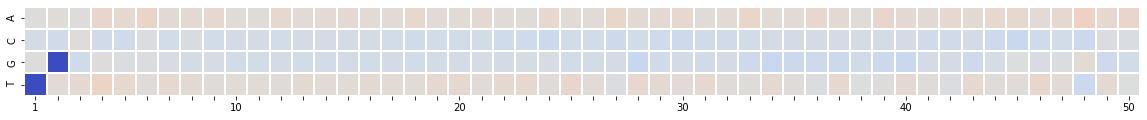

In [14]:
plot_meta(e_test, model, subset='lowest_ten')

602


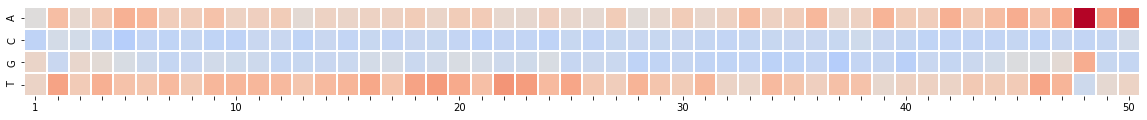

In [15]:
plot_meta(e_test, model, subset='highest_ten'

<font color=lightblue size=20>Attribution MRL w/ uAUGs</font>

In [19]:
e_test = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/MRL_pred.csv')


model = keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/data/models/main_MRL_model.hdf5')

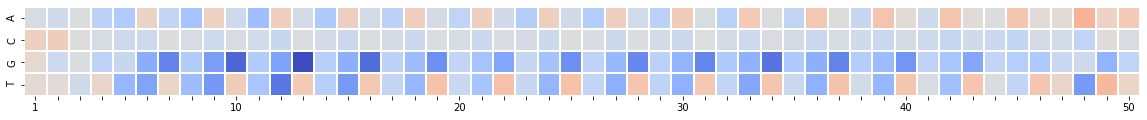

In [20]:
plot_meta(e_test, model)

2000


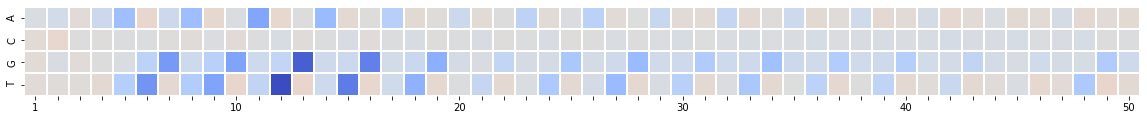

In [21]:
plot_meta(e_test, model, subset='lowest_ten')

2000


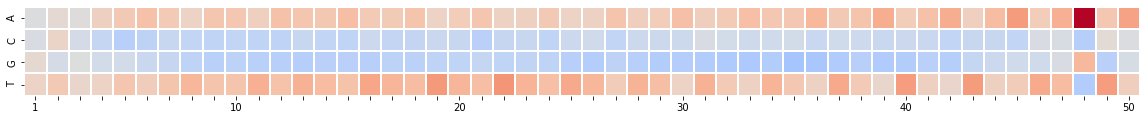

In [22]:
plot_meta(e_test, model, subset='highest_ten')

<font color=lightblue size=20>Attribution hMRL w/ uAUGs</font>

In [23]:
e_test = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/hMRL_human_50_test_pred.csv')

model = keras.models.load_model('/Users/frederickkorbel/Documents/projects/paper/data/models/human_MRL_model.hdf5')

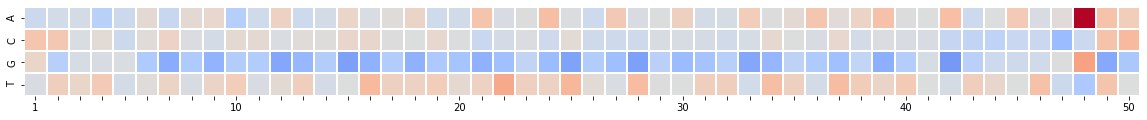

In [46]:
plot_meta(e_test, model)

500


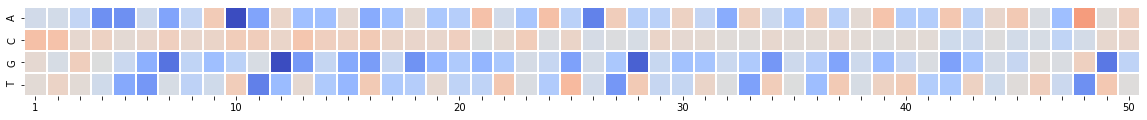

In [44]:
plot_meta(e_test, model, subset='lowest_ten')

500


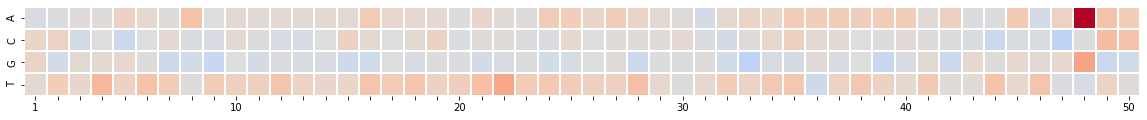

In [45]:
plot_meta(e_test, model, subset='highest_ten')

<font color=lightblue size=20>Attribution hMRL w/o uAUGs</font>

In [ ]:
e_test = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/hMRL_human_50_test_pred.csv')
e_train = pd.read_csv('/Users/frederickkorbel/Documents/projects/paper/data/hMRL_human_50_train.csv')


e_test = e_test[e_test['utr'].apply(lambda x: 'ATG' not in x)]
e_train = e_train[e_train['utr'].apply(lambda x: 'ATG' not in x)]
print("There are ", len(e_test), " UTRs left in the test set.")
print("There are ", len(e_train), " UTRs left in the train set.")

seq_e_train = one_hot_encode(e_train,seq_len=50)
seq_e_test = one_hot_encode(e_test, seq_len=50)

e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

hmrl_model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=10,border_mode='same',
                   inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
                   dropout2=0,dropout3=0.2)

e_test = test_data(df=e_test, model=hmrl_model, obs_col='rl',test_seq=seq_e_test)
r = r2(e_test['rl'], e_test['pred'])
print('r-squared = ', r)

In [ ]:
plot_meta(e_test, model, subset=None)

In [ ]:
plot_meta(e_test, model, subset='lowest_ten')

In [ ]:
plot_meta(e_test, model, subset='highest_ten')